# Pocking at Ever Larger Language Models
## An introduction to language models for (digital) humanists
### From Neural to Pretrained Language Models


Sources used in this tutorial
- The Programming Historian lesson on [Interrogating a National Narrative with GPT-2
](https://programminghistorian.org/en/lessons/interrogating-national-narrative-gpt).
- Jurafsky & Martin, Speech and Language Processing (3rd ed. draft), available [online](https://web.stanford.edu/~jurafsky/slp3/)

## What are language models?

LMs tell us what is likely to come next in a sequence. More technically:

> “[Language models] assign a probability* to each possible next word. (Jurafsky & Martin)”

Given the sentence **“Predicting the future is hard, but not …”**

- P(“impossible” | sentence) is greater than P(“aardvark” | sentence)


> Read P(“impossible” | sentence) as the probability of observing the token “impossible” given the sequence “Predicting the future is hard, but not ...


> Probabilities are values between 0 and 1 that sum up to 1.

**Peaking ahead**: if you can predict what comes next in a text sequence you learn quite a lot about language use and the world in general.

- Paris is located in [BLANK]
- He was late. I was really angry and told [BLANK]

## Quick recap
- Language modelling is the task of predicting the next word *w* given a history *h* (i.e. **P(w | h)**).
- At each step, it computes the probability distribution over **all the following words**.
- We can measure the **performance** of a model by evaluating how well a model can predict the next word (it will assign higher probabilities to actual texts).

## Pretrained Language Models

- Transition from N-Gram to Neural Language Models (ca. 2013)
    - Word2Vec: Predict the **center word** given a context of n words, or predict context given a center word (**fixed windows**)
- Around 2017-18 Pretrained Language Models took over
    - **PLMs** trained with a different objective: predict the next word given a sequence (or predict masked words in a sequence (**variable length**))
    - Models become 'larger', **more parameters**, and can model word meaning in context (instead of having a global meaning representation). To be explained in more detail later!



## Terminology: Parameters and size, what are we talking about?

<img src="https://soundgas.com/wp-content/uploads/2021/02/Vintage-mixers-from-Roland-Yamaha-1024x576.jpg" alt="knobs" width="500">

- Parameters are "knobs" you can adjust to transform an input to the output you want
- For a language model, the input is a sentence, the output is a probability over words (which should resemble the actual next word)
- Deep Learning algorithms attempt to find the optimal setting of these knobs. The more knobs, the more complex stuff you can do (but equally, it becomes harder to understand how the machine actually works).

![simpleNN](https://miro.medium.com/v2/resize:fit:624/1*U3FfvaDbIjr7VobJj89fCQ.png)





## Common PLM variants


Determined by the language modelling task:
- **Causal/Autoregressive Language Models** (GPT series): Predict the next [BLANK]
- **Masked Language Models** (BERT and family): Predict the [BLANK] word.

Let's have a closer look at a real language model: GPT-2. To work with (large) language models, we will be relying on the HuggingFace's `transformer` library.

## Hugging Face 🤗 and the Transformers library

Hugging Face is a company specialised in distributing deep learning models and data. 

Their open source `transformers` library has become one of the most popular libraries for NLP:
* State-of-the-art NLP easier to use.
* Provides APIs to download and use pretrained models, but also allows you to load and fine-tune your own models.
* It is open source! 
* Maintains a **hub**: central point for people to share (and find) **models** and **data**. They host more than 241K models, supporting different languages and different tasks, and also more than 45K datasets.

We'll just scratch the surface, but if you are interested in this, we highly recommend the Hugging Face course: https://huggingface.co/course

### What are Transformers (the T in GPT and BERT)

A **transformer** is a deep learning model that uses the **attention** mechanism (a mechanism which is based on cognitive attention, and which focuses on where the key information in a sequence is produces while forgetting less relevant information). Its development has had a huge impact in deep learning, especially in natural language processing and computer vision. It allows a more effective modeling of long term dependencies between the words in a sequence, and more efficient training, not limited by the sequence order of the input sequence.

You can read the original paper [here](https://arxiv.org/abs/1706.03762). It is by far the most impactful paper (in computer science and machine learning) of the last decade and 79588 citations on Google Scholar (last checked 29/06/2023 at 6:58 AM)



### Install the required Hugging Face libraries 

In [ ]:
%%bash
pip install transformers xformers accelerate datasets

## Text Generation with GPT-2

LMs are generative model.

- it learn the underlying structure of a given dataset
- and generates new samples that are similar to the examples it was trained on. 

**In other words, it learns the patterns and relationships within the data and uses that knowledge to produce new, previously unseen data points.**

Why is generating texts interesting for DH research? 
- Can we use 'fictitious' data?
- We are sampling from universe of texts that could have been...
- ...but have experimental control by prompting the model in different ways?
- If the model learns some valuable patterns and associations, we can interrogate it's behaviour.



While more complex, GPT-2 operates similarly to a simple N-Gram LM.
- Given a prompt or input sequence, it returns a **probability over the following word**
- Then we can sample a word from this distribution, add it to the prompt, and repeat!

Materials inspired by this [blog post](https://huggingface.co/blog/how-to-generate) and the excellent Programming Historian lesson.



## One token at a time: next word prediction with GPT-2

Next word prediction is the building block of generative AI and we will also encounter it when playing with larger language models such as GPT-3 or ChatGPT.

In the following example, we generate just one toke to show a language model creates a probability distribution over possible next words.

In [12]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Model
import numpy as np
from torch.nn import Softmax
import pandas as pd
# initialize softmax function
softmax = Softmax(dim=0) 

### Exercise: 

Change the prompt and observe how the outcome distribution of words changes. We only look at the hundred most probably words.

To code below is merely for illustrative purposes, don't worry if some things are unclear at the moment. If you want to delve deeper in machine learning with Hugging Face, there are excellent tutorials available. See for example the [Hugging Face Course](https://huggingface.co/learn/nlp-course/chapter1/1)

In [13]:
prompt = 'Hello my name is' # define a prompt

<AxesSubplot:>

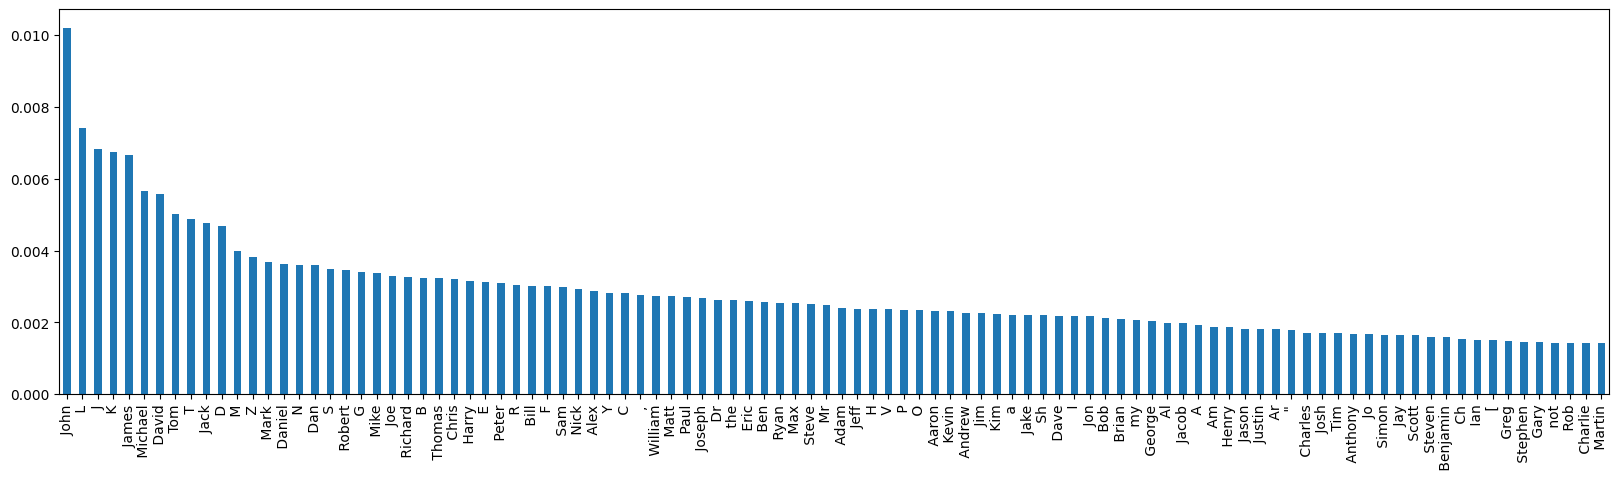

In [14]:
# tokenizer will split a text in units the LM is built on
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
# add the EOS token as PAD token to avoid warnings
model = GPT2LMHeadModel.from_pretrained("gpt2", pad_token_id=tokenizer.eos_token_id)
# load the gpt-2 model
gpt2 = GPT2Model.from_pretrained("gpt2", pad_token_id=tokenizer.eos_token_id)
# get logits from model
predictions = model(**tokenizer(prompt, return_tensors='pt')) 
# the predictions as logits
# predictions.logits.shape 
# get words with highest probability
tokenizer.decode(np.argmax(predictions.logits[0,-1,:].detach().numpy()))
# order predictions
series = pd.Series(softmax(predictions.logits[0,-1,:]).detach()).sort_values(ascending=False)
# change token_ids to the actual tokens
index = [tokenizer.decode(x) for x in series.index] 
# set tokens as index
series.index = index 
# plot results
series[:100].plot(kind='bar',figsize=(20,5)) 

## Generating texts from prompts

The preceding process is rather cumbersone, we just generated one additional word. The `transformers` library provides more convenient functions for generating texts based on a prompt using the `pipeline` function.

In [ ]:
from transformers import pipeline

In [ ]:
generator = pipeline('text-generation', # define the task
                     model = 'gpt2', # define the model
                     pad_token_id=tokenizer.eos_token_id)


In [ ]:
#sequence = 'the duke of'
#sequence = 'A no deal Brexit'
prompt = 'The UK is' # select the prompt

In [ ]:
generator(prompt, 
            max_length = 30,  # max length of each generated text
            num_return_sequences=3 # how many sequence to generate
         )

### ✏️ 1. Exercise: 

Change the prompt and observe how this affects text generation. We only look at the hundred most probably words.

## Refining Text Generation

There are multiple settings we can adjust to drive the text generation in specific direction.

## Temperature
A very common parameter is `temperature` (which we will also encounter when playing with larger language models). 

Temperature regulates the creativity of a language model.

Increasing the temperature can make predictions more creative (or random if you [like](https://medium.com/mlearning-ai/softmax-temperature-5492e4007f71#:~:text=Temperature%20is%20a%20hyperparameter%20of%20LSTMs%20(and%20neural%20networks%20generally,utilize%20the%20Softmax%20decision%20layer.)))


Image taken for this [blogpost](https://medium.com/mlearning-ai/softmax-temperature-5492e4007f71) on temperature in Softmax.

![temperature](https://miro.medium.com/v2/resize:fit:1400/format:webp/0*7xj72SjtNHvCMQlV.jpeg)


In [ ]:
import torch
torch.manual_seed(0)
generator(sequence, 
          max_length = 30, 
          num_return_sequences=5,
          do_sample=True, 
          top_k = 0,
          temperature=.000000001, # change temparature to .7
         )


### Top k sampling

To prevent that outliers will mess up the generation, you can restrict the options and select only a word from the k most probable. 

In [ ]:
generator(sequence, 
          max_length = 30, 
          do_sample=True, 
          num_return_sequences=2,
          top_k=50)

### Top p or nucleus sampling

Another strategy is to sample from the smallest set of words whose cumulative probability exceeds the probability p.

In [ ]:
generator(sequence, 
          max_length = 30, 
          do_sample=True, 
          num_return_sequences=2,
          top_k=0,
          top_p=.92)

## Adapting a language model

It is possible to change a language model by further training or fine-tuning it on new documents. Based on the tutorial on GPT-2 in Programming Historian we trained a model on news snippets related to Brexit. In other words, we've built a GPT-Brexit model on top of GPT-2.



In [ ]:
from transformers import pipeline
generator = pipeline('text-generation', model = 'Kaspar/gpt-brexit',tokenizer='gpt2',pad_token_id=tokenizer.eos_token_id)


### ✏️ 2. Exercise: 

- Define a prompt implicitly related to Brexit (for example "The UK is").
- Using the `pipeline` can you generate 3 documents with GPT-2 and GPT-Brexit.
- Does this show interesting difference, how would you about studying these models? How valuable is text generation as a tool for DH research?

In [ ]:
# write answer here

### ✏️ 3. Exercise: 

Find another model for text generation on the Hugging Face hub, inspect the model card and generate some text.

In [ ]:
# write answer here

## Modeling Meaning in Context with BERT

**BERT** (Bidirectional Encoder Representations from Transformers) is a transformer-based model that creates contextualized word embeddings: it is able to capture fine-grained contextual distinctions and properties of words. It learns contextualized information through a masking process (i.e. it hides some words and uses their position to infer them back).

Masked language modeling is the task of hiding tokens in a sequence with a **mask token**, and prompting the model to fill that mask with an appropriate token (source: https://huggingface.co/transformers/task_summary.html#masked-language-modeling). 

The `fill-mask` pipeline replaces the mask in a sequence by the most likely prediction according to a BERT model.

We will create a `fill-mask` pipeline using the `distilbert-base-uncased` English model (and its tokenizer), as follows:

In [ ]:
masker = pipeline("fill-mask", model='bert-base-uncased')

In [ ]:
sentence = """When a cell has been produced, we can then trace some of the
            stages by which new [MASK] are formed. There appear to be four
            modes in which vegetable cells are multiplied. The new cells
            may either proceed from a nucleus or they may be formed at
            once in the protoplasm."""

outputs = masker(sentence)

# Let's print the results in an easier-to-read format:
for o in outputs:
    print("Prediction:", o['token_str'])
    print("Score:     ", round(o['score'],4))
    print()

In [ ]:
sentence = """Imprisonment with proper employment, and at least two visits
            every day from a prison officer. The punishment does not
            extend over a month. A week must elapse before the same
            prisoner can be put again into the dark [MASK]."""

outputs = masker(sentence)

# Let's print the results in an easier-to-read format:
for o in outputs:
    print("Prediction:", o['token_str'])
    print("Score:     ", round(o['score'],4))
    print()

### ✏️ 4. Exercise: 

Think of another highly ambiguous word (e.g. "bank") and apply the same procedure as above to assess if BERT manages to distinguish the different senses. You can make this increasingly difficult, to test the limits of the model?

In [ ]:
# write answer here

### ✏️ 5. Exercise: 

Hugging Face provides BERT models in other languages, or even multilingual models. Search the hub for BERT (or similar masked language models) in any other language than English and apply the "fill-mask" pipeline.

In [ ]:
# write answer here

### Tracing Semantic Change with Masked Language Models

In [ ]:
sentence = "Our sewing [MASK] stood near the wall where grated windows admitted sunshine, and their hymn to Labour was the only sound that broke the brooding silence."

In [ ]:
masker = pipeline("fill-mask", model='bert-base-uncased')
print(masker(sentence))

In [ ]:
victorian_masker = pipeline("fill-mask", model='Livingwithmachines/bert_1760_1850')
print(victorian_masker(sentence))

# Text Classification with BERT
## The Living Machine case study

Another popular task is supervised classification with text: 
- classify document according to particular categories

This requires:
- examples in the form of labeled data
- a model that can learn the relation between the text and labels

Once this is done (to some satisfaction) we can apply this model and 
    - genre classification
    - emotion detection
    - "machine animacy" or "living machines"
    
Again, the code below is more for illustrative purposes, and you are not required to understand everything. We merely want to show what steps are involved for training a text classification model. Much of this code will be useful if you'd like to create your own classifier!

In [ ]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score
from datasets import load_dataset, Value
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorWithPadding

### Annotate and load data

In [ ]:
# load dataset from the huggingface hub
dataset = load_dataset('biglam/atypical_animacy') 
# inspect the first three examples
dataset['train'][3]

### Process dataset

In [ ]:
# remove the columns we don't need
dataset = dataset.remove_columns(['id', 'context', 'target', 'humanness', 'offsets', 'date'])
# rename column to a common format
dataset = dataset.rename_columns({'animacy':'label','sentence':'text'})

In [ ]:
# initially all data is training data
dataset = dataset['train']
dataset

In [ ]:
# insepect the outcome of this process
dataset[3]

In [ ]:
# because we want to do binary classification
# we need to convert the labels from float to int 
# for this we can use the .cast() function in datasets
new_features = dataset.features.copy()
new_features["label"] = Value("int32")
dataset = dataset.cast(new_features)
dataset[3]

### Split data into training and test set

To train a model we need 
- **training set**: observations (examples and labels) used for finding the optimal parameters
- **validation set**: observation used to monitor how the model performs during training
- **test set**: a held-out set to evaluate the trained model (often not available). This tells us how well the model generalizes beyond the observations it has seen during during.

In [ ]:
test_size = int(len(dataset)*.3) # set 30% apart as test set
train_test = dataset.train_test_split(test_size=test_size , seed=42) # split data into train and test
test_set = train_test['test']
val_size = int(len(train_test['train'])*.05) # use 5% of the training data for validation
train_val =  train_test['train'].train_test_split(test_size=val_size,seed=42) # split into training and validation set

### Load a Pretrained Language Model and Tokenizer

In [ ]:
checkpoint = 'distilbert-base-uncased' # load a checkpoint 
tokenizer = AutoTokenizer.from_pretrained(checkpoint) # load a tokenizer
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,num_labels=2) # load a model

### Tokenize and preprocess data 

In [ ]:
# we proprocess data by converting texts to token ids
def preprocess_function(examples, target_col):
    return tokenizer(examples['text'], truncation=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
train_val = train_val.map(preprocess_function)

## Train Model on Annotated Examples

In [ ]:
training_args = TrainingArguments(
    output_dir=f"../results", # where to save the model
    seed = 42, # ensure the experiment is reproducible
    learning_rate=1e-3, # how aggressively should we update the model weights
    per_device_train_batch_size=8, # how many examples per batch
    per_device_eval_batch_size=8, # how many examples per batch
    num_train_epochs=3, # how many times should we iterate over the training data
    weight_decay=0.01, # how much should we reduce the reduce the learning rate
        )

trainer = Trainer(
    model=model, # model to train
    args=training_args, # training arguments
    train_dataset=train_val["train"], # training data
    eval_dataset=train_val["test"], # validation data
    tokenizer=tokenizer, # tokenizer
    data_collator=data_collator, # collates examples and presents tham as input
        )

trainer.train() # train the model

### Predict label for sentence

In [ ]:
text = """But no muscle moved on his face, no unusual twinkle came to his eye ; 
  he apparently said : " I am a machine , sir, and always obey the stronger force, and that without dissent.
"""
tokenized_text = tokenizer(text, truncation=True, return_tensors="pt").to('cuda')

In [ ]:
outputs = model(**tokenized_text)
outputs

### Evaluate on test examples

In [ ]:
test_set = test_set.map(preprocess_function,fn) # preprocess test data
predictions = trainer.predict(test_set) # get predictions, probabilities for each class
preds = np.argmax(predictions.predictions, axis=-1) # get the most probable as the predicted class
accuracy_score(preds,predictions.label_ids) # how accurate is the model, percentage correct

## (Optional) The feature extraction pipeline

Here we will see how to get vectors for words in context.

Similarly to what we did with word2vec, we may also want to have access to the vector of a certain word. However, unlike with word2vec, the vector of a word will depend on the context in which the word occurs. This means that we can't just ask for the vector of the word "apple", for example: we will need to ask for the vector of the word "apple" given a certain context.

We first import the following two libraries, which will help us work with vectors:

In [ ]:
import numpy as np # python library used for working with vectors
from scipy import spatial # package to help compute distance or similarity between vectors

The pipeline task to obtain the vectors for tokens in a sequence is `feature-extraction`. As you can see, creating this pipeline is very similar to creating the `fill-mask` pipeline.

We will store the pipeline in a variable called `nlp_features`:

In [ ]:
nlp_features = pipeline("feature-extraction",
                    model='distilbert-base-uncased',
                    tokenizer='distilbert-base-uncased')

Given a sentence, the pipeline tokenizes the input sentence:

In [ ]:
sentence = "They were told that the machines stopped working."

output = nlp_features(sentence)
output_vectors = np.squeeze(output) # This removes single-dimensional entries (i.e. for vector readability)

Let's inspect the output. First of all, let's print it:

In [ ]:
print(output_vectors)

This is an array (a list of vectors). Let's see its shape:

In [ ]:
print(output_vectors.shape) # Print the shape of the vector

This means that we have an arrray (in other words a matrix, a table) that has 11 vectors of length 768 (or, in other words, 11 rows with 768 columns).

**Question:** 11 vectors? Why 11?

Let's see how the sentence is tokenized (we've seen how above):

In [ ]:
# Load the **SAME** tokenizer used in the pipeline:
our_tokenizer = transformers.AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Encode the sentence into a sequence of vocabulary IDs
encoded_seq = our_tokenizer.encode(sentence)
print(encoded_seq)

# And get the tokens given the vocabulary IDs
tokens = our_tokenizer.convert_ids_to_tokens(encoded_seq)
print(tokens)

# And print the length of the tokenized sequence:
print(len(tokens))

As you can see, the input sentence has been tokenized into 11 tokens. So what we have in the above array is 11 vectors (each one representing a word in the context of the sentence, **keeping the order of tokens**, i.e. the first vector will correspond to the special token `[CLS]`, the second vector to the token `the`, and so on until the last vector, which corresponds to the special token `[SEP]`).

How do we get the vector of a specific token?

In [ ]:
print(tokens[6]) # The 6th element in the tokenized sentence is the token `machine` (we start counting from zero)

In [ ]:
print(output_vectors[6]) # Therefore, o the 6th vector in output_vectors is the vector of `machine` in this context.

### ✏️ 6. Exercise: 

In [ ]:
# Create two `feature-extraction` pipelines, one for the  1760-1850 model, and
# one for the 1890-1900 model. Find whether the cosine similarity between words
# in sequences change depending on which BERT model you use.
# 
# Type your code here:

# Fin.